# Medium Reinforcement Learning

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time
from celluloid import Camera

In [2]:
env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
env = gym.make(env_name).env

obs = env.reset()
# env.render()

In [3]:
env.action_space.n

3

In [4]:
# env.action_space.low, env.action_space.high

In [5]:
nv = env.unwrapped
env.seed()
np.random.seed(1)

In [6]:
n_states = 40
J = 100

## Functions

In [7]:
def discretization(env, obs, n_states):#
    """
    This function
    """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled


In [8]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [9]:
def visualise_actions(mat, ax =None):
    if ax == None:
        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot()
    labels = ["Move Left", "Don't Accelerate", "Move Right"]
    cmap = plt.cm.get_cmap('Blues', 8) 
    ax.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat, cmap = cmap)
    ax.set_xlabel("Position", fontsize = 15)
    ax.set_ylabel("Velocity", fontsize = 15)
    # ax.set_title("Approximate Value Function", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
    ax.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
               [labels[i] for i in range(3)])

In [148]:
def visualise_conf(mat):
    plt.figure(figsize = (10,10))

    cmap = plt.cm.get_cmap('Blues', 8) 
    plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat, cmap = cmap)
    plt.xlabel("Position", fontsize = 15)
    plt.ylabel("Velocity", fontsize = 15)
    # plt.title("Confidence Plot?", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
#     plt.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
#                [labels[i] for i in range(3)])

## TABULAR METHOD

In [32]:
def tabular_method(
    n_states = 40,
    episodes = 1000,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.95,
    max_stps = 100000,
    epsilon = 0.05):
    
    q_table = np.zeros((n_states, n_states, env.action_space.n))

    tabular_steps = []
    
    q_table_l = []
    q_table_l.append(q_table)
    
    for episode in range(episodes):

        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))

        steps = 0
        while True:

            pos, vel = discretization(env, obs, n_states)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n) #for discrete action space
            else:
                a = np.argmax(q_table[pos][vel])
            try:
                obs, reward, terminate,_ = env.step(a)
                
            except Exception as e:
                print("ACTION", a) 
                print(e)
                return()
            total_reward += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs, n_states)
            pos_, vel_ = int(pos_), int(vel_)

            # Q function update
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
     
            steps += 1
            if steps%max_stps == 0:
                print("FAILED")
                break
            if terminate:
                tabular_steps.append(steps)
                if episode % 100 == 0:
                    print("Episode:", episode, "Alpha: ", alpha, "Steps: ", steps)
                break
        q_table_l.append(np.copy(q_table))
    env.close()
    return(q_table_l, tabular_steps)

In [33]:
q_table_l, tabular_steps= tabular_method(n_states)

Episode: 0 Alpha:  1.0 Steps:  33643
Episode: 100 Alpha:  0.95 Steps:  855
Episode: 200 Alpha:  0.9025 Steps:  422
Episode: 300 Alpha:  0.8573749999999999 Steps:  397
Episode: 400 Alpha:  0.8145062499999999 Steps:  282
Episode: 500 Alpha:  0.7737809374999998 Steps:  243
Episode: 600 Alpha:  0.7350918906249998 Steps:  233
Episode: 700 Alpha:  0.6983372960937497 Steps:  249
Episode: 800 Alpha:  0.6634204312890623 Steps:  236
Episode: 900 Alpha:  0.6302494097246091 Steps:  339


### Test the result

In [ ]:
for e in range(5):
    obs = env.reset()
    steps = 0
    while True:
        pos, vel = discretization(env, obs, n_states)
        pos, vel = int(pos), int(vel)
        a = np.argmax(q_table_l[-1][pos][vel])
        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >= 1000:
            print("FAILED")
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

In [125]:
n_states= 200

In [144]:
np.argmax(q_table_l[-1], axis = 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


<Figure size 432x288 with 0 Axes>

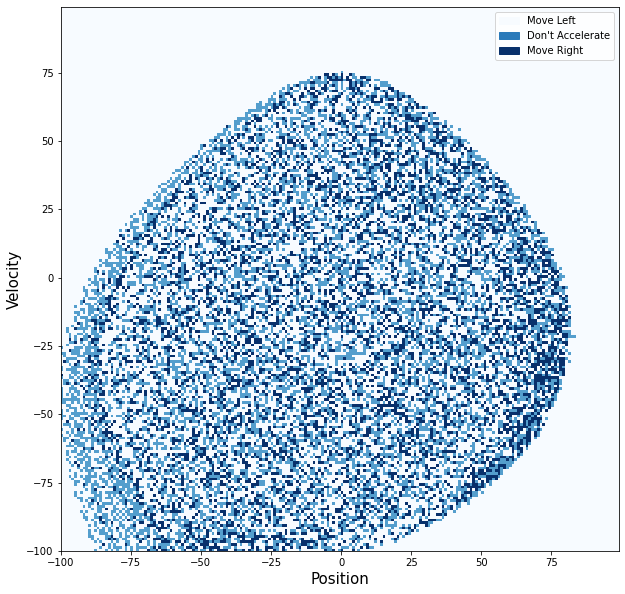

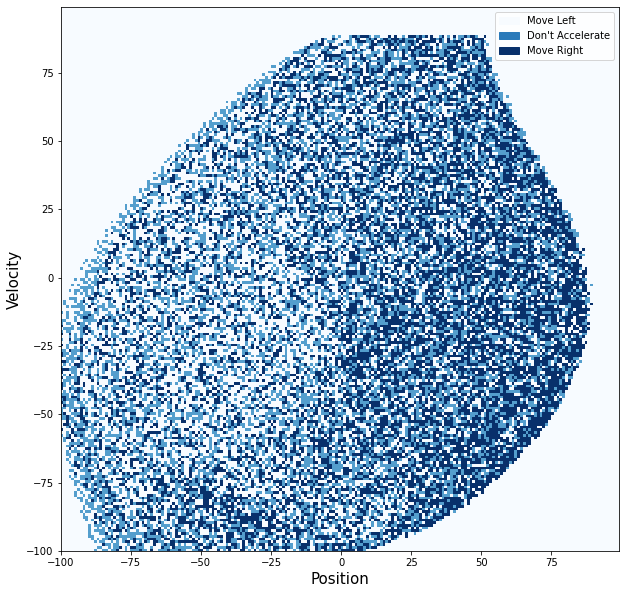

In [145]:
fig = plt.figure()

for i in [q_table_l[3], q_table_l[-1]]:
    mat_actions = np.argmax(i, axis =2)
    
    visualise_actions(mat_actions) #make gif of this
    plt.show

## Making Animations

In [91]:
# fig = plt.figure()
# camera = Camera(fig)
# ax = fig.add_subplot()

# for index, i in enumerate(q_table_l[::3]):
#     if index%100 == 0:
#         print(index, "/", len(q_table_l))
    
#     mat_actions = np.argmax(i, axis =2)
    
#     visualise_actions(mat_actions, ax) #make gif of this
    
#     plt.clf
#     camera.snap()
#     plt.show()

In [92]:
# animation = camera.animate(interval = 20, repeat = True, repeat_delay = 5000)

In [93]:
# animation.save('anim_ value_func_full.gif', writer='PillowWriter', fps=30)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


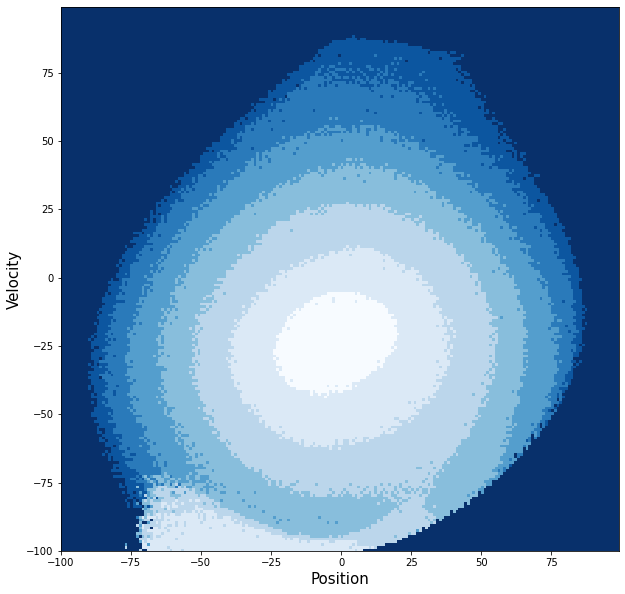

In [149]:
mat_actions = np.max(q_table_l[-1], axis =2)
    
visualise_conf(mat_actions)

# Gradient Descent Functions

In [7]:
q_table = q_table_l[-1]

NameError: name 'q_table_l' is not defined

In [8]:
q_table.shape

NameError: name 'q_table' is not defined

In [13]:
def construct_states(n = n_states):
    states = []
    for i in range(n):
        for j in range(n):
            for k in range(3):
#                 print(i, j, k)
                states.append(np.array([i, j,k]))
    states = np.asarray(states)
    return(states)

In [14]:
states = construct_states(n_states)

In [15]:
states

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [39, 39,  0],
       [39, 39,  1],
       [39, 39,  2]])

In [16]:
def get_means(J):
    """
    Getting J cluster centers for the radial basis model
    """
#     print(df_values.shape)
    X = states #state space is the position, velocity and action
    means = []

    N = len(states)
    sig = np.std(X)
    
    for i in range(3):
        means.append(np.linspace(X[:, i].min(), X[:, i].max(), J))
    means  = np.array(means).T
    print(means.shape)
    U = np.zeros((N,J))

    for i in range(N):
        for j in range(J):
            U[i][j] = np.exp(-0.5 *np.linalg.norm(X[i] - means[j])/(sig))
    
    return(U, means)

In [17]:
U, kmeans = get_means(J)

(100, 3)


In [18]:
def evaluate_action(pos, vel, a, w):
    """
    Getting the value from a state
    
    input: state, action, weights vector
    
    Output: value of action in that state
    
    Method: convert the state and action into the design matrix, then dot product the weights 
    
    """
    states = np.array([pos, vel, a])
    U = []
    for j in range(J):
        U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
    return(U @ w, U)

In [19]:
def evaluate_state(pos, vel, w):
    """
    RBF for the values of all possible actions from that state
    
    """
    vals = []
    for act in range(3):
        U = []
        states = np.array([pos, vel, act])
        for j in range(J):
            U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
        vals.append(U @ w)
    return(vals)

In [20]:
X = states #state space is the position, velocity and action
sig = np.std(X)

# Online Learning Algorithms

In [21]:
def discretization_online(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low)# / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled =(obs[0] - pos_low) / pos_den   #int((obs[0] - pos_low) / pos_den)
    vel_scaled = (obs[1] - vel_low) / vel_den#int((obs[1] - vel_low) / vel_den)
    return(pos_scaled, vel_scaled)


In [22]:
def learn_online(mode = "q_learning", n_states = 40,
    episodes = 50,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.99,
    max_stps = 100000,
    epsilon = 0.05):
    
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()

    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    
    steps_count = []


    w = np.random.rand(J, 1)
    
    
    for episode in range(episodes):
        
            
        # by solving bellmans equations for a number of episodes we can optain a value function of that policy at every state
        # we can improve the policy (what is the action im going to take given a state)

        obs = env.reset()

        alpha = max(min_lr, initial_lr*(gamma**(episode/0.1)))# max(min_lr, initial_lr*(gamma**(episode//100)))
        
        steps = 0
        while True:

            pos, vel = discretization_online(env, obs)

            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
                a_value, U = evaluate_action(pos, vel, a, w)
            else:
                a = np.argmax(evaluate_state(pos, vel, w))
                a_value, U = evaluate_action(pos, vel, a, w)

            obs, reward, terminate,_ = env.step(a)
            pos_, vel_ = discretization_online(env, obs)

            if mode == "sarsa":
                if np.random.uniform(low=0, high=1) < epsilon:

                    next_val = np.random.choice(np.array(evaluate_state(pos_,vel_, w)).reshape(3))
                else:
                    next_val = np.max(evaluate_state(pos_,vel_, w)) 

            elif mode == "q_learning":
                next_val = np.max(evaluate_state(pos_,vel_, w))
            else:
                raise ValueError('Please choose either sarsa or q_learning')
            # Q function update

            w += (alpha * (reward + gamma*next_val - a_value) * U).reshape(J,1)


            steps += 1
            
            if steps%max_stps == 0:
                print("FAILED")
                break
            if terminate:
                steps_count.append(steps)
                print("Episode:", episode, "Steps: ", steps)
                break
    return(w, steps_count)

In [23]:
w_q_learning, q_learning_steps = learn_online("q_learning")

Episode: 0 Steps:  9536
Episode: 1 Steps:  756
Episode: 2 Steps:  514
Episode: 3 Steps:  508
Episode: 4 Steps:  686
Episode: 5 Steps:  364
Episode: 6 Steps:  209
Episode: 7 Steps:  528
Episode: 8 Steps:  125
Episode: 9 Steps:  276
Episode: 10 Steps:  220
Episode: 11 Steps:  389
Episode: 12 Steps:  127
Episode: 13 Steps:  202
Episode: 14 Steps:  248
Episode: 15 Steps:  136
Episode: 16 Steps:  800
Episode: 17 Steps:  459
Episode: 18 Steps:  133
Episode: 19 Steps:  230
Episode: 20 Steps:  206
Episode: 21 Steps:  572
Episode: 22 Steps:  132
Episode: 23 Steps:  374
Episode: 24 Steps:  682
Episode: 25 Steps:  236
Episode: 26 Steps:  205
Episode: 27 Steps:  652
Episode: 28 Steps:  293
Episode: 29 Steps:  891
Episode: 30 Steps:  1731
Episode: 31 Steps:  220
Episode: 32 Steps:  524
Episode: 33 Steps:  220
Episode: 34 Steps:  160
Episode: 35 Steps:  382
Episode: 36 Steps:  290
Episode: 37 Steps:  1386
Episode: 38 Steps:  302
Episode: 39 Steps:  300
Episode: 40 Steps:  852
Episode: 41 Steps:  221

In [24]:
w_sarsa, sarsa_steps = learn_online("sarsa")

Episode: 0 Steps:  5518
Episode: 1 Steps:  4430
Episode: 2 Steps:  429
Episode: 3 Steps:  644
Episode: 4 Steps:  375
Episode: 5 Steps:  136
Episode: 6 Steps:  215
Episode: 7 Steps:  422
Episode: 8 Steps:  123
Episode: 9 Steps:  918
Episode: 10 Steps:  128
Episode: 11 Steps:  132
Episode: 12 Steps:  126
Episode: 13 Steps:  223
Episode: 14 Steps:  612
Episode: 15 Steps:  1521
Episode: 16 Steps:  278
Episode: 17 Steps:  1596
Episode: 18 Steps:  516
Episode: 19 Steps:  137
Episode: 20 Steps:  294
Episode: 21 Steps:  160
Episode: 22 Steps:  680
Episode: 23 Steps:  572
Episode: 24 Steps:  157
Episode: 25 Steps:  374
Episode: 26 Steps:  223
Episode: 27 Steps:  640
Episode: 28 Steps:  299
Episode: 29 Steps:  928
Episode: 30 Steps:  136
Episode: 31 Steps:  1069
Episode: 32 Steps:  132
Episode: 33 Steps:  303
Episode: 34 Steps:  214
Episode: 35 Steps:  217
Episode: 36 Steps:  300
Episode: 37 Steps:  292
Episode: 38 Steps:  1053
Episode: 39 Steps:  132
Episode: 40 Steps:  651
Episode: 41 Steps:  

In [25]:
w_sarsa

array([[ 1.71082304],
       [ 4.1650299 ],
       [ 2.94143257],
       [ 0.83927318],
       [-0.86123796],
       [-1.76261329],
       [-2.75411606],
       [-2.84627248],
       [-3.15716707],
       [-4.00562374],
       [-3.78369644],
       [-4.17312041],
       [-4.21609862],
       [-3.90702724],
       [-4.78423933],
       [-4.77073083],
       [-4.82448383],
       [-3.98647936],
       [-4.00544544],
       [-3.87019823],
       [-3.71189019],
       [-3.83660717],
       [-4.11552826],
       [-3.73454056],
       [-4.33236329],
       [-3.7443567 ],
       [-4.17310659],
       [-3.30290757],
       [-3.65610792],
       [-3.69321361],
       [-3.7730119 ],
       [-3.19299549],
       [-3.44087707],
       [-3.25866969],
       [-3.73878805],
       [-3.07091625],
       [-3.00801577],
       [-2.93539595],
       [-2.54152044],
       [-2.73715851],
       [-2.993996  ],
       [-2.85184758],
       [-2.52750386],
       [-3.1020688 ],
       [-2.43360945],
       [-2

In [26]:
def generate_table(w, n_states = n_states):
    table = np.zeros([n_states,n_states])
    step = 0
    for i in range(n_states):
        for j in range(n_states):

            table[i][j] = np.argmax(evaluate_state(i/n_states, j/n_states, w))
            step += 1
    return(table)

In [27]:
sarsa_tab = generate_table(w_sarsa)
q_learning_tab = generate_table(w_q_learning)

In [28]:
(sarsa_tab == 2).sum()

1572

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


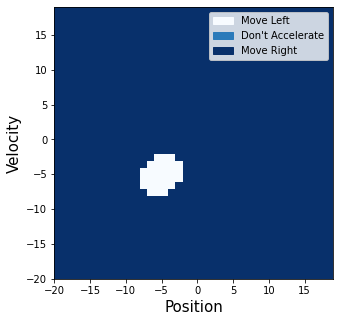

In [29]:
visualise_actions(sarsa_tab)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


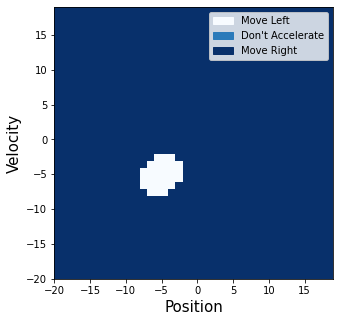

In [30]:
visualise_actions(q_learning_tab)

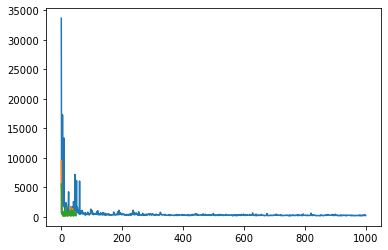

In [37]:
for i in [tabular_steps, q_learning_steps, sarsa_steps]:
    plt.plot(range(len(i)), i)

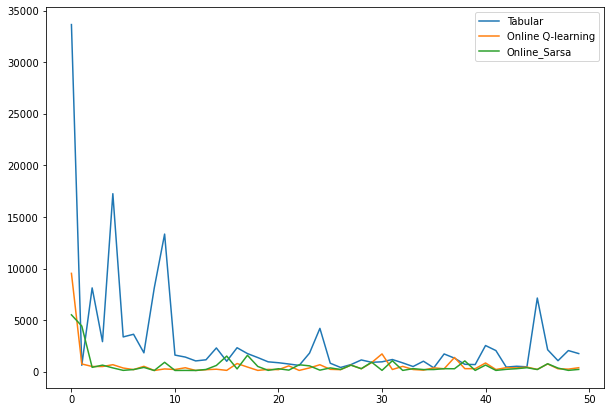

In [36]:
labels = ["Tabular", "Online Q-learning", "Online_Sarsa"]
plt.figure(figsize = (10, 7))
for index, i in enumerate([tabular_steps[:50], q_learning_steps, sarsa_steps]):
    plt.plot(range(len(i)), i, label = labels[index])
plt.legend()

## RUN Q_LEARNING

In [84]:
for e in range(5):
    obs = env.reset()
    steps = 0
    while True:
        # env.render()
        pos, vel = discretization_online(env, obs)

        a = np.argmax(evaluate_state(pos, vel, w_q_learning))

        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >= 10000:
            print("FAILED")
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

FAILED
FAILED
FAILED
FAILED
246


## RUN SARSA

In [95]:
epsilon = 0.05

In [96]:
for e in range(5):
    obs = env.reset()
    steps = 0
    while True:
        # env.render()
        pos, vel = discretization_online(env, obs)

        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
   
        else:
             a = np.argmax(evaluate_state(pos, vel, w_sarsa))
        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >= 10000:
            print("FAILED")
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

633
2044
1258
460
540


In [97]:
q_learning_tab

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])